In [1]:
# Import required libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy as sp
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from collections import Counter

In [2]:
# Set time range of 24 years
t = pd.date_range(start='31/10/2000', end='31/10/2024', freq='ME')

# Define column names for the equities
equity_columns = [
    'JOHNSON & JOHNSON',
    'BOSTON SCIENTIFIC',
    'ELI LILLY',
    'PFIZER', 
    'TELEFLEX',
    'CIGNA',
    'REVVITY',
    'MEDTRONIC', 
    'LABCORP HOLDINGS',
    'HUMANA'
    ]
    
# Generate lists for total return indices and market value indices
equity_TRI_columns = [f"{name} - TOT RETURN IND" for name in equity_columns]
equity_MV_columns  = [f"{name} - MARKET VALUE"   for name in equity_columns]

In [3]:
# Download risk free interest rates (skipping rows 1,2 because they are not actual market values but additional information)
rF_yearly = pd.read_excel('INTEREST_RATE.xlsx', usecols=['US FEDERAL FUNDS RATE (MONTHLY AVERAGE) NADJ'], skiprows=[1, 2], header=0)

# Verify there are no NaN values in the DataFrame
assert not rF_yearly.isnull().values.any(), "DataFrame contains NaN values"

# Adding a missing value for October 2024, required since other files contain this data. 
# Source: https://www.federalreserve.gov/releases/h15/
rF_yearly.loc[len(rF_yearly)] = 4.92

# Compute monthly rates
rF = np.array(rF_yearly / 12)

In [4]:
# Market indices

# Download overall equity market index
health_MKT = pd.read_excel('STOXX_HEALTH_PI.xlsx', usecols=['STOXX NTH AMER 600 HEALTH CARE E - PRICE INDEX'])

# Verify there are no NaN values in the DataFrame
assert not health_MKT.isnull().values.any(), "DataFrame contains NaN values"

# Conversion in percentual montlhy variance
rMKT = 100 * (np.log(health_MKT) - np.log(health_MKT.shift(1)))

# Drop the first row (since log returns are computed as difference between consecutive data, first row will be NaN)
# Calculation of Excess Market Returns from risk-free Market Returns
rMKT = np.array(rMKT[1:])
eMKT = np.subtract(rMKT, rF[1:])

In [5]:
# Market value of constituents

# Download market value of constituents
mkt_value = pd.read_excel('MKT_VALUE.xlsx', usecols=equity_MV_columns, skiprows=[1, 2], header=0)
# Reorder the columns explicitly to match the correct order 
mkt_value = mkt_value[equity_MV_columns]

# Verify there are no NaN values in the DataFrame
assert not mkt_value.isnull().values.any(), "DataFrame contains NaN values"

#-----------------------------------------------------------------------------------------------------------------------------------#
# Equities

# Download equities
data = pd.read_excel('Stocks_Constituents.xlsx', usecols=equity_TRI_columns)
# Reorder the columns explicitly to match the correct order 
data = data[equity_TRI_columns]
# Verify there are no NaN values in the DataFrame
assert not data.isnull().values.any(), "DataFrame contains NaN values"

In [6]:
# Calculate the log returns for all equities
log_returns = 100 * (np.log(data) - np.log(data.shift(1)))

# Drop the first row (since log returns are computed as difference between consecutive data, first row will be NaN)
log_returns = log_returns.iloc[1:]

# Verify there are no other NaN values in the DataFrame
assert not log_returns.isnull().values.any(), "DataFrame contains NaN values"

# Broadcasting rF across columns in log_return to create the result dataframe
eEquities = log_returns.sub(rF[1:], axis=0)

In [7]:
# Adds an intercept (constant) term to eMKT
eMKT_with_const   = sm.add_constant(eMKT)

In [8]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Perform linear regression on the portfolio

# Compute the weights
weights           = mkt_value.div(mkt_value.sum(axis=1), axis=0)
# Rename columns in both DataFrames so that pandas doesn't cry when performing element-wise multilpication 
weights.columns   = equity_columns
eEquities.columns = equity_columns
# Compute weighted average
avg_return        = weights[1:] * eEquities
# Sum across columns to get the portfolio return for each row
ePortfolio        = avg_return.sum(axis=1)

In [9]:
FF5 = pd.read_excel('FF5.xlsx')
CPI = pd.read_excel('CPI.xlsx')

MKT = pd.read_excel('FF5.xlsx', usecols=['Mkt-RF'])
SMB = pd.read_excel('FF5.xlsx', usecols=['SMB'])
HML = pd.read_excel('FF5.xlsx', usecols=['HML'])
CMA = pd.read_excel('FF5.xlsx', usecols=['CMA'])
RMW = pd.read_excel('FF5.xlsx', usecols=['RMW'])
OIL = pd.read_excel('CPI.xlsx', usecols=['OIL'])
CPI = pd.read_excel('CPI.xlsx', usecols=['CPI'])
PPI = pd.read_excel('CPI.xlsx', usecols=['PPI CHEMICAL'])
IND_PROD = pd.read_excel('CPI.xlsx', usecols=['US INDUSTRIAL PRODUCTION - MANUFACTURING (NAICS) VOLA'])

logCPI = 100 * (np.log(CPI) - np.log(CPI.shift(1)))
logIND_PROD = 100 * (np.log(IND_PROD) - np.log(IND_PROD.shift(1)))

In [10]:
Y = ePortfolio[3:-1]
X = np.column_stack((np.ones_like(ePortfolio[3:-1]),eMKT[3:-1], MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]))
var_names = ['Intercept', 'eMKT', 'MKT', 'SMB', 'HML', 'RMW', 'CMA', 
             'logCPI', 'OIL', 'PPI', 'logIND_PROD']
Res1 = sm.OLS(Y , X).fit()
Res1.model.data.xnames = var_names
print(Res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     107.7
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           1.14e-88
Time:                        14:28:24   Log-Likelihood:                -589.55
No. Observations:                 284   AIC:                             1201.
Df Residuals:                     273   BIC:                             1241.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.4405      0.530     -0.831      

In [11]:
#regredisco la variabile MktRF sulle altre per calcolare il VIF
X = np.column_stack((np.ones_like(ePortfolio[3:-1]),eMKT[3:-1], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]))
var_names = ['Intercept', 'eMKT', 'SMB', 'HML', 'RMW', 'CMA', 
             'logCPI', 'OIL', 'PPI', 'logIND_PROD']
Res4 = sm.OLS(MKT[1:] , X).fit()
Res4.model.data.xnames = var_names
print(Res4.summary())

                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     49.26
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           2.84e-52
Time:                        14:28:24   Log-Likelihood:                -695.88
No. Observations:                 284   AIC:                             1412.
Df Residuals:                     274   BIC:                             1448.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1760      0.769      0.229      

In [12]:
VIF = 1/(1-0.618)

In [13]:
VIF

2.6178010471204187

In [14]:
data = np.column_stack((eMKT[3:-1], MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]))
df   = pd.DataFrame(data, columns=['eMKT', 'MKT', 'SMB', 'HML', 'RMW', 'CMA', 'logCPI', 'OIL', 'PPI', 'logIND_PROD'])
# Calculating the correlation matrix
corr_matrix = df.corr()

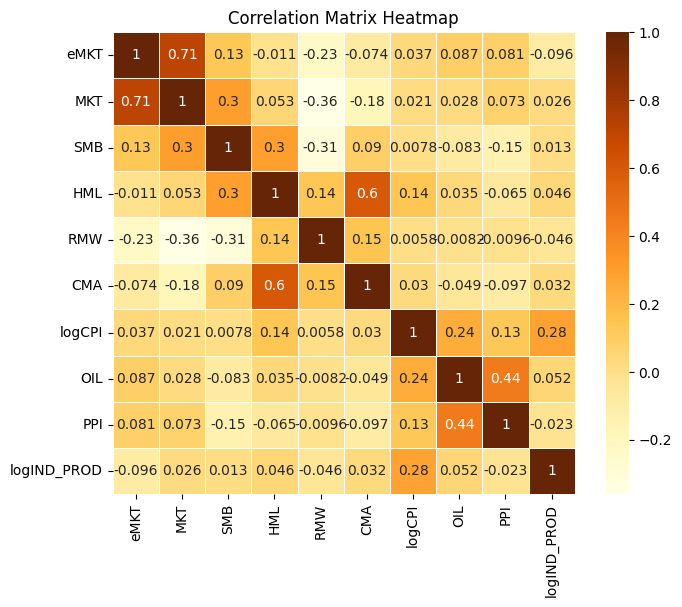

In [15]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Plot correlation matrix in a very pleasant way
vmin, vmax = corr_matrix.min().min(), corr_matrix.max().max()
centre     = (vmax + vmin)/2
palette    = sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap=palette, center=centre, linewidths=0.5, square=True)
plt.title("Correlation Matrix Heatmap")
plt.savefig('Correlation_heatmap.png')
plt.show()

In [16]:
X    = np.column_stack((np.ones_like(Y), eMKT[3:-1], MKT[1:], SMB[1:], CMA[1:], logIND_PROD[1:]))
var_names3 = ['Intercept', 'eMKT', 'MKT', 'SMB', 'CMA', 'logIND_PROD']
Res3 = sm.OLS(Y, X).fit()
Res3.model.data.xnames = var_names3
print(Res3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     211.6
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           1.50e-92
Time:                        14:28:25   Log-Likelihood:                -593.57
No. Observations:                 284   AIC:                             1199.
Df Residuals:                     278   BIC:                             1221.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1628      0.119      1.365      

In [17]:
RSSU = Res1.ssr
RSSR = Res3.ssr
Fstat =(( RSSR - RSSU ) /5) /( RSSU /(273) )
Pval =1 - sp.stats.f.cdf(Fstat, 5, 273)
print(f"p-value={Pval}")

p-value=0.16946250825472986


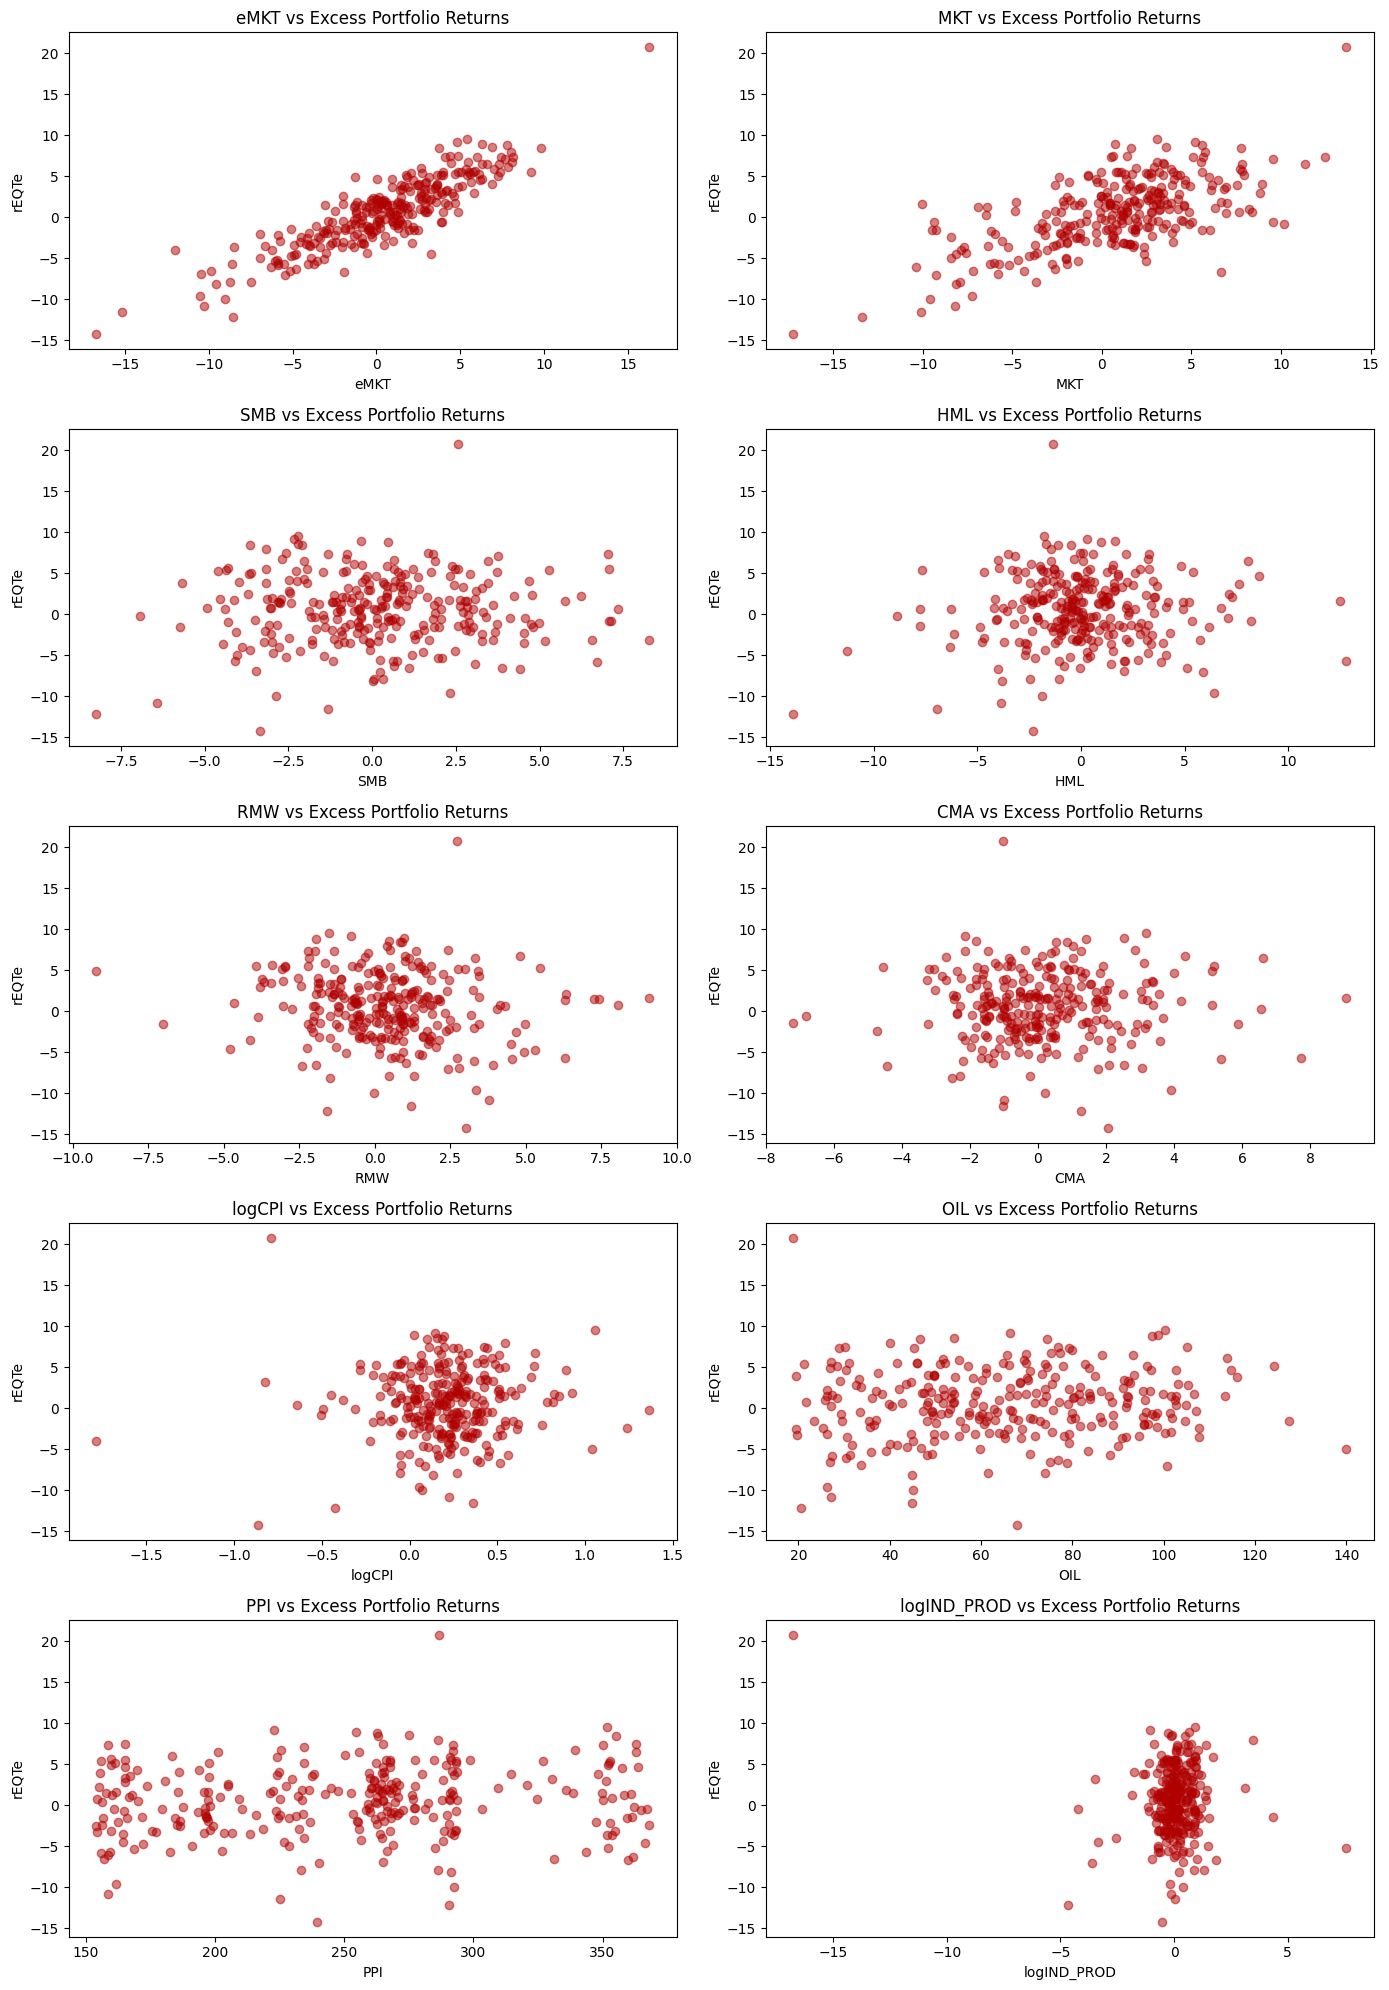

In [18]:
list_scatter    = [eMKT[3:-1], MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]]
indicator_names = ['eMKT', 'MKT', 'SMB', 'HML', 'RMW', 'CMA', 'logCPI', 'OIL', 'PPI', 'logIND_PROD']

# Calculate the number of rows needed with two plots per row (creating an extra row if there's an odd number of equities)
num_rows  = (len(list_scatter)   + 1) // 2  

# Create the figure and axis grid
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 4 * num_rows))
# Flatten the grid for easy indexing
axes      = axes.flatten() 

# Loop through each equity column and create a scatter plot
for i, (F, name) in enumerate(zip(list_scatter, indicator_names)):
    axes[i].scatter(F, ePortfolio[3:-1], alpha=0.5, color='#b00000')
    axes[i].set_title(f'{name} vs Excess Portfolio Returns')
    axes[i].set_xlabel(f'{name}')
    axes[i].set_ylabel('rEQTe')

# Hide any unused subplots if the number of equities is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Make sure the layout is pretty
plt.tight_layout()
plt.savefig('scatterplot_multivariate_regression.png')
plt.show()

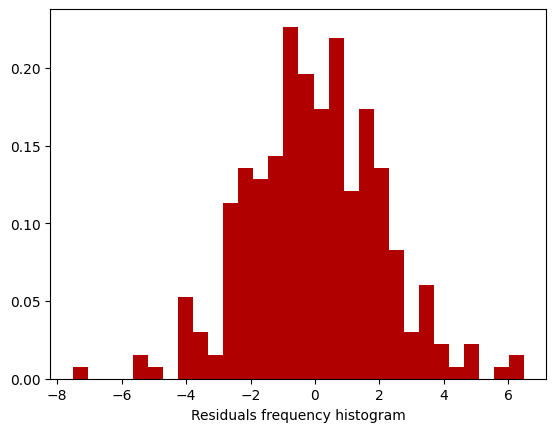

In [19]:
X    = np.column_stack((np.ones_like(Y), eMKT[3:-1]))
Res2 = sm.OLS(Y ,X).fit()
rs2  = Res2.resid

# frequency histogram
plt.hist(rs2, bins=30, density= True, color='#b00000')
plt.xlabel('Residuals frequency histogram')
plt.show()

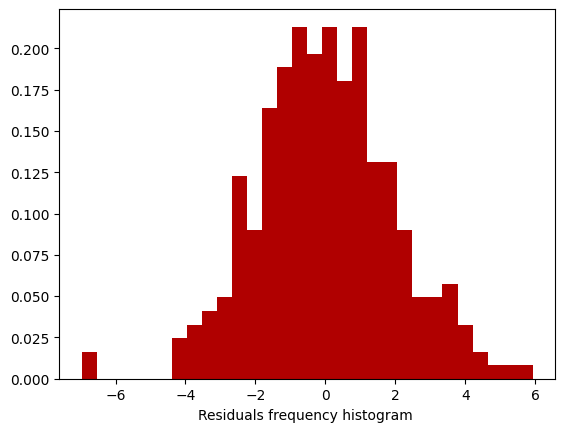

In [20]:
X    = np.column_stack((np.ones_like(Y), eMKT[3:-1], MKT[1:], SMB[1:], CMA[1:], logIND_PROD[1:]))
Res3 = sm.OLS(Y, X).fit()
rs3  = Res3.resid
# frequency histogram
plt.hist(rs3, bins=30, density= True, color='#b00000')
plt.xlabel('Residuals frequency histogram ')
plt.show()

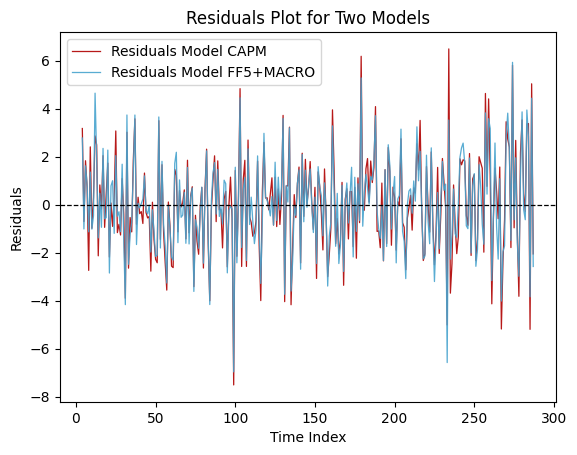

Correlation: 0.9496580857309653


In [21]:
plt.plot(rs2, color='#b00000', linewidth=.92, alpha=.9, label='Residuals Model CAPM')
plt.plot(rs3, color='#47a3ce', linewidth=.92, alpha=.9, label='Residuals Model FF5+MACRO')
plt.title('Residuals Plot for Two Models')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.axhline(0, color='0', linestyle='--', linewidth=.9)
plt.legend()
plt.grid(False)
plt.show()
# Compute the correlation between residuals
correlation_res = np.corrcoef(rs2, rs3)[0, 1]
print(f"Correlation: {correlation_res}")

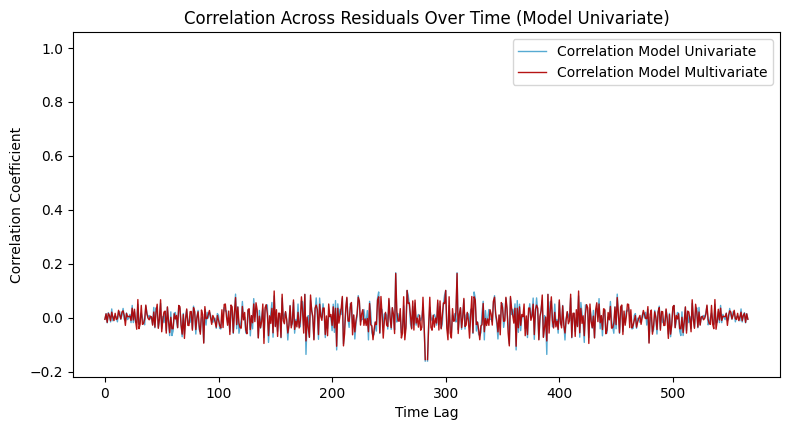

In [22]:
# Calculate the correlation coefficients at each time point for each model
correlation_across_time_model1 = np.correlate(rs2, rs2, mode='full')
correlation_across_time_model2 = np.correlate(rs3, rs3, mode='full')

# Exclude a small neighborhood around the central peak by setting it to NaN

# Normalize the correlation coefficients, excluding NaN values
normalized_correlation_model1 = correlation_across_time_model1 / np.nanmax(np.abs(correlation_across_time_model1))
normalized_correlation_model2 = correlation_across_time_model2 / np.nanmax(np.abs(correlation_across_time_model2))

# Visualize the correlation across residuals over time for each model
plt.figure(figsize=(8, 8))

# Plot correlation across residuals over time for Model 1
plt.subplot(2, 1, 2)
plt.plot(normalized_correlation_model1, color='#47a3ce', alpha=.92, linewidth=1,
        label='Correlation Model Univariate')
plt.plot(np.arange(len(normalized_correlation_model2)), normalized_correlation_model2, color='#b00000', alpha=.92, linewidth=1,
        label='Correlation Model Multivariate')
plt.title('Correlation Across Residuals Over Time (Model Univariate)')
plt.xlabel('Time Lag')
plt.ylabel('Correlation Coefficient')
plt.legend()

#In the midpoint it creates outliers due to its construction, so it was added this for loop that eliminate outliers from the 
#central point of the graph
for ax in plt.gcf().get_axes():
    for line in ax.get_lines():
        y_data = line.get_ydata()
        x_data = line.get_xdata()
        line.set_ydata(np.where(y_data > 0.3, np.nan, y_data))

plt.tight_layout()
plt.show()

In [23]:

var_names2 = ['Intercept', 'eMKT']
Res2.model.data.xnames = var_names2
print(Res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     940.3
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           8.40e-92
Time:                        14:28:31   Log-Likelihood:                -608.24
No. Observations:                 284   AIC:                             1220.
Df Residuals:                     282   BIC:                             1228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2162      0.123      1.755      0.0